RESNET Implementation -- Base model

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import torch
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop,Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

In [2]:
!unzip /content/cnn_dataset.zip -d /content/cnn_dataset1

Streaming output truncated to the last 5000 lines.
  inflating: /content/cnn_dataset1/vehicles/5499.jpg  
  inflating: /content/cnn_dataset1/vehicles/55.jpg  
  inflating: /content/cnn_dataset1/vehicles/550.jpg  
  inflating: /content/cnn_dataset1/vehicles/5500.jpg  
  inflating: /content/cnn_dataset1/vehicles/5501.jpg  
  inflating: /content/cnn_dataset1/vehicles/5502.jpg  
  inflating: /content/cnn_dataset1/vehicles/5503.jpg  
  inflating: /content/cnn_dataset1/vehicles/5504.jpg  
  inflating: /content/cnn_dataset1/vehicles/5505.jpg  
  inflating: /content/cnn_dataset1/vehicles/5506.jpg  
  inflating: /content/cnn_dataset1/vehicles/5507.jpg  
  inflating: /content/cnn_dataset1/vehicles/5508.jpg  
  inflating: /content/cnn_dataset1/vehicles/5509.jpg  
  inflating: /content/cnn_dataset1/vehicles/551.jpg  
  inflating: /content/cnn_dataset1/vehicles/5510.jpg  
  inflating: /content/cnn_dataset1/vehicles/5511.jpg  
  inflating: /content/cnn_dataset1/vehicles/5512.jpg  
  inflating: /cont

In [3]:
dataset_folder = '/content/cnn_dataset1'

In [4]:
data_sn = []
labels_sn = []

In [5]:
#preprocessing the images by normalzing the pixel values of the images
for category_sn in os.listdir(dataset_folder):
    category_path_sn = os.path.join(dataset_folder, category_sn)
    if os.path.isdir(category_path_sn):
        for image_file_sn in os.listdir(category_path_sn):
            image_path_sn = os.path.join(category_path_sn, image_file_sn)
            image_sn = cv2.imread(image_path_sn)
            if image_sn is not None:
                image_sn = tf.cast(image_sn, tf.float32)
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                image_sn = (image_sn - mean) / std
                data_sn.append(image_sn) #adding images
                labels_sn.append(category_sn)#adding corresponding labels

In [6]:
# Converting data and labels to the Numpy arrays
data_sn = np.array(data_sn)
labels_sn = np.array(labels_sn)

In [7]:
# Converting the labels to the categorical values
label_encoder_sn = LabelEncoder()
encoded_labels_sn = label_encoder_sn.fit_transform(labels_sn)
categorical_labels_sn = to_categorical(encoded_labels_sn)

In [8]:
# Splitting the dataset into training, testing, and validation sets
train_data_sn, test_data_sn, train_labels_sn, test_labels_sn = train_test_split(data_sn, categorical_labels_sn, test_size=0.2, random_state=42)
train_data_sn, val_data_sn, train_labels_sn, val_labels_sn = train_test_split(train_data_sn, train_labels_sn, test_size=0.1, random_state=42)

In [9]:
train_data_tensor = torch.tensor(train_data_sn.transpose(0, 3, 1, 2), dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_sn, dtype=torch.float32)

val_data_tensor = torch.tensor(val_data_sn.transpose(0, 3, 1, 2), dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels_sn, dtype=torch.float32)

test_data_tensor = torch.tensor(test_data_sn.transpose(0, 3, 1, 2), dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_sn, dtype=torch.float32)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
#creating residual block for the resnet - 18 architecture
#that we are creating
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()

        # creting the First convo layer of the Resnet- 18
        #and adding the batch normalization and the correspondng activation function (RElu) for the 1st convo layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu_activation = nn.ReLU(inplace=True)

        # creting the Second convo layer of the Resnet- 18
        # In second convo layer we are just adding the batch normalization and
        #there is no regualarization added to it.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        # along with the batch normalization we are also adding Downsampling the layer
        #for matching the dimensions
        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    #forward pass for the resnet architectrure
    def forward(self, x):
        # Storing the inputs as this will be used for the residual connection
        identity = x

        # First convolutional block
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu_activation(out)

        # Second convolutional block
        out = self.conv2(out)
        out = self.batch_norm2(out)

        # Applying the downsample to match dimensions
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Adding the residual connection
        out += identity
        out = self.relu_activation(out)

        return out


In [ ]:
class ResNet18(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        super(ResNet18, self).__init__()
        self.input_channels = 64

        # Initializing CNN layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        #usign kernel size 7 and stride and padding as 2,3 respectively
        #also used batch normalization, relu activation function for this layer also we have added maxpooling layer
        #as well weith kernel size as 3 and stride as 2
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu_activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Creating the corresponding ResNet layers
        self.layer1 = self._create_resnet18_layer(block, 64, layers[0], stride=1) #resnet layer -1 -> 64
        self.layer2 = self._create_resnet18_layer(block, 128, layers[1], stride=2)#resnet layer -2 -> 128
        self.layer3 = self._create_resnet18_layer(block, 256, layers[2], stride=2)#resnet layer -3 -> 256
        self.layer4 = self._create_resnet18_layer(block, 512, layers[3], stride=2)#resnet layer -4 -> 512

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) #added the avg pooling layer to the netwokr
        #and finally added a layer that gives the output to the number of classifiers from 512 -> total number of classifiers.
        self.fc = nn.Linear(512, num_classes)

    def _create_resnet18_layer(self, block, out_channels, blocks, stride=1):
        #created a list for storign the layers of the network
        layers = []
        layers.append(block(self.input_channels, out_channels, stride))
        self.input_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.input_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu_activation(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
#Initiating the restnet 18 model
resnet_model = ResNet18(ResidualBlock, [2, 2, 2, 2], num_classes=3)

In [ ]:
import torch.optim as optim

# Defining the loss function and optimizer for the resnet model that we used
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    resnet_model.train() #training the resnet model
    run_loss = 0.0
    real = 0
    complete = 0
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet_model(batch_data)
        loss = criterion(outputs, torch.argmax(batch_labels, dim=1))
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        _, predicted = outputs.max(1)
        complete += batch_labels.size(0)
        real += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

    # Validation loop of the model
    resnet_model.eval()
    val_loss = 0.0 #validation loss for the network
    correct = 0 #number of correct smaples
    total = 0 #total number of samples
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            outputs = resnet_model(batch_data)
            loss = criterion(outputs, torch.argmax(batch_labels, dim=1))
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()
    #storing the values and calcualtign the corresponding loss of validaiton
    #and its accuracy as well for each epoch for the trained resnet
    #architectrue model
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {run_loss/len(train_loader)}, Training Accuracy: {real/complete}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {correct / total}")



Epoch 1/3, Training Loss: 0.4613387879950029, Training Accuracy: 0.8217592592592593, Validation Loss: 0.6214175069332123, Validation Accuracy: 0.7208333333333333
Epoch 2/3, Training Loss: 0.33153067492776445, Training Accuracy: 0.8756018518518518, Validation Loss: 0.430925213098526, Validation Accuracy: 0.8404166666666667
Epoch 3/3, Training Loss: 0.28458130651050145, Training Accuracy: 0.8929166666666667, Validation Loss: 0.33058168590068815, Validation Accuracy: 0.8758333333333334


In [ ]:
#evaluating the model fdor finding the testing loss and its corresponding accuracy

resnet_model.eval()
test_correct = 0 #total correct samples that it predicted correct
test_total = 0 #total number of test samples
test_predictions = []
true_labels = []
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        outputs = resnet_model(batch_data)
        _, predicted = torch.max(outputs, 1)
        test_total += batch_labels.size(0)
        test_correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()
        test_predictions.extend(predicted.cpu().numpy())
        true_labels.extend(torch.argmax(batch_labels, dim=1).cpu().numpy())
#calculating and printing the accuracy of the resnet model after evaluating the model.
print(f"Test Accuracy: {test_correct / test_total}")


Test Accuracy: 0.8695


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(true_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1566  200  236]
 [ 113 1732  151]
 [  63   20 1919]]


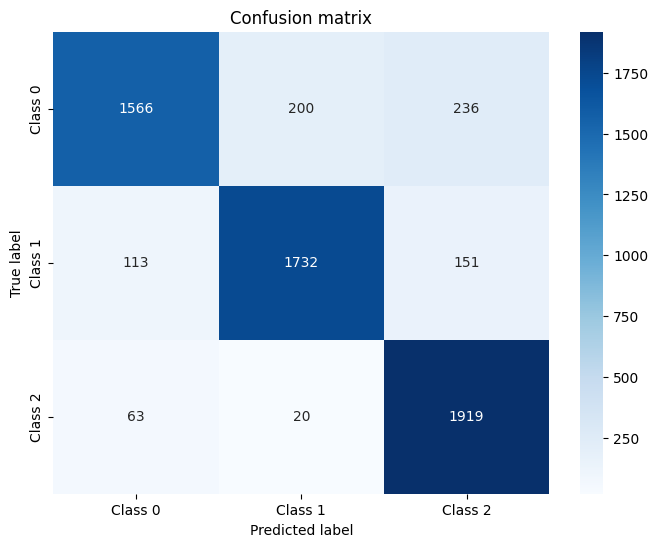

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1', 'Class 2']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion matrix")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [ ]:
class_report = classification_report(true_labels, test_predictions)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      2002
           1       0.89      0.87      0.88      1996
           2       0.83      0.96      0.89      2002

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



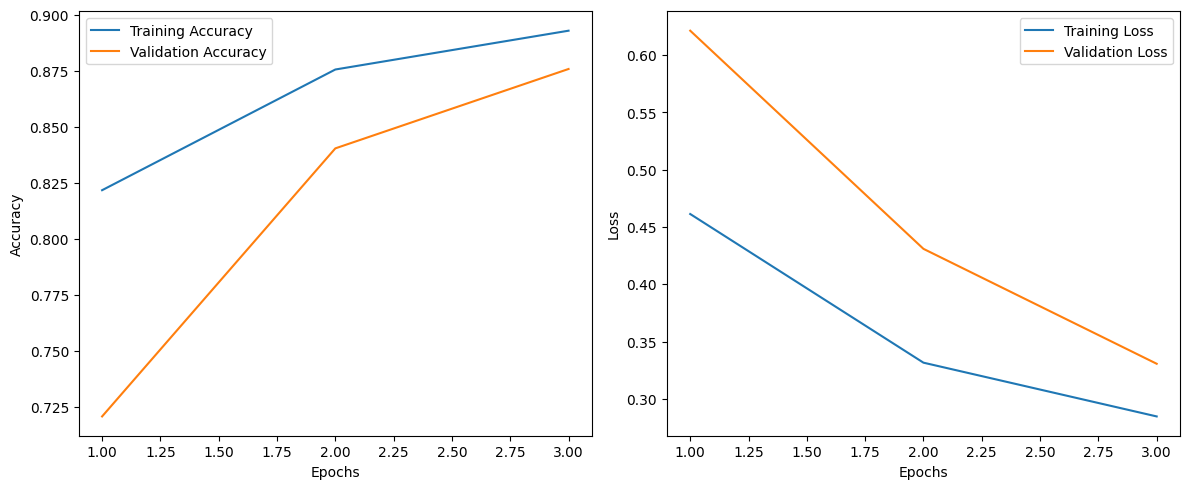

In [ ]:
import matplotlib.pyplot as plt

training_acc_list = [0.8217592592592593,0.8756018518518518,0.8929166666666667]
validation_acc_list = [0.7208333333333333,0.8404166666666667,0.8758333333333334]
training_loss_list = [0.4613387879950029,0.33153067492776445,0.28458130651050145]
validation_loss_list= [0.6214175069332123,0.430925213098526,0.33058168590068815]
# Plot training and validation accuracy over time
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1),training_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1),validation_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over time
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),training_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1),validation_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


RESNET Implementation using regularization and dropout


In [11]:
import torch.nn as nn

class ResidualBlock_rd(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_prob=0.5):
        super(ResidualBlock_rd, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu_activation = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_prob)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu_activation(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu_activation(out)

        return out


In [12]:

class ResNet18_rd(nn.Module):
    def __init__(self, block, layers, num_classes=3, dropout_prob=0.5, weight_decay=1e-4):
        super(ResNet18_rd, self).__init__()
        self.input_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu_activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._create_resnet18_layer(block, 64, layers[0], stride=1, dropout_prob=dropout_prob)
        self.layer2 = self._create_resnet18_layer(block, 128, layers[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self._create_resnet18_layer(block, 256, layers[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self._create_resnet18_layer(block, 512, layers[3], stride=2, dropout_prob=dropout_prob)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _create_resnet18_layer(self, block, out_channels, blocks, stride=1, dropout_prob=0.5):
        layers = []
        layers.append(block(self.input_channels, out_channels, stride, dropout_prob=dropout_prob))
        self.input_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.input_channels, out_channels, dropout_prob=dropout_prob))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu_activation(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [13]:
resnet_model_rd = ResNet18_rd(ResidualBlock_rd, [2, 2, 2, 2], num_classes=3)

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model_rd.parameters(), lr=0.001)

In [16]:
num_epochs = 3
for epoch in range(num_epochs):
    resnet_model_rd.train() #training the resnet model
    run_loss = 0.0
    real = 0
    complete = 0
    for batch_data, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet_model_rd(batch_data)
        loss = criterion(outputs, torch.argmax(batch_labels, dim=1))
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
        _, predicted = outputs.max(1)
        complete += batch_labels.size(0)
        real += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

    # Validation loop of the model
    resnet_model_rd.eval()
    val_loss = 0.0 #validation loss for the network
    correct = 0 #number of correct smaples
    total = 0 #total number of samples
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            outputs = resnet_model_rd(batch_data)
            loss = criterion(outputs, torch.argmax(batch_labels, dim=1))
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()
    #storing the values and calcualtign the corresponding loss of validaiton
    #and its accuracy as well for each epoch for the trained resnet
    #architectrue model
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {run_loss/len(train_loader)}, Training Accuracy: {real/complete}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {correct / total}")


Epoch 1/3, Training Loss: 0.5575618950305161, Training Accuracy: 0.7778703703703703, Validation Loss: 1.0021165041128794, Validation Accuracy: 0.6695833333333333
Epoch 2/3, Training Loss: 0.4222550657612306, Training Accuracy: 0.8377777777777777, Validation Loss: 0.8947466349601746, Validation Accuracy: 0.6533333333333333
Epoch 3/3, Training Loss: 0.36440299220659117, Training Accuracy: 0.8633796296296297, Validation Loss: 0.31349470317363737, Validation Accuracy: 0.8816666666666667


In [18]:
#evaluating the model fdor finding the testing loss and its corresponding accuracy

resnet_model_rd.eval()
test_correct_rd = 0 #total correct samples that it predicted correct
test_total_rd = 0 #total number of test samples
test_predictions_rd = []
true_labels_rd = []
with torch.no_grad():
    for batch_data, batch_labels in test_loader:
        outputs = resnet_model_rd(batch_data)
        _, predicted = torch.max(outputs, 1)
        test_total_rd += batch_labels.size(0)
        test_correct_rd += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()
        test_predictions_rd.extend(predicted.cpu().numpy())
        true_labels_rd.extend(torch.argmax(batch_labels, dim=1).cpu().numpy())
#calculating and printing the accuracy of the resnet model after evaluating the model.
print(f"Test Accuracy: {test_correct_rd / test_total_rd}")


Test Accuracy: 0.8726666666666667


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_rd = confusion_matrix(true_labels_rd, test_predictions_rd)
print("Confusion Matrix:")
print(conf_matrix_rd)

Confusion Matrix:
[[1829  143   30]
 [ 282 1692   22]
 [ 167  120 1715]]


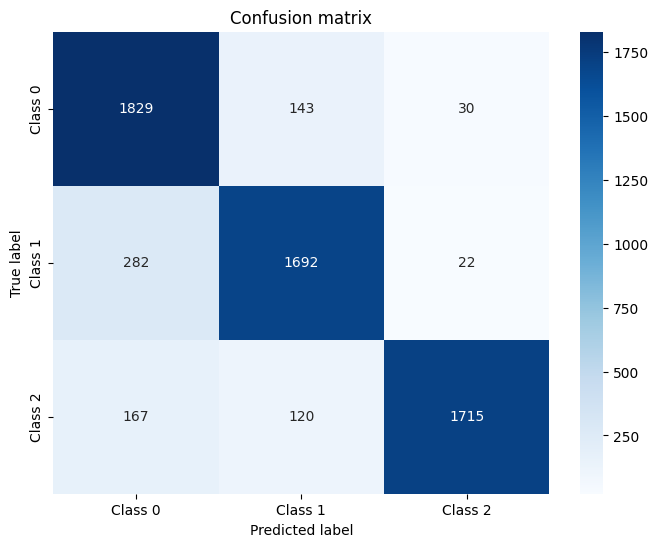

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
class_labels = ['Class 0', 'Class 1', 'Class 2']
sns.heatmap(conf_matrix_rd, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion matrix")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


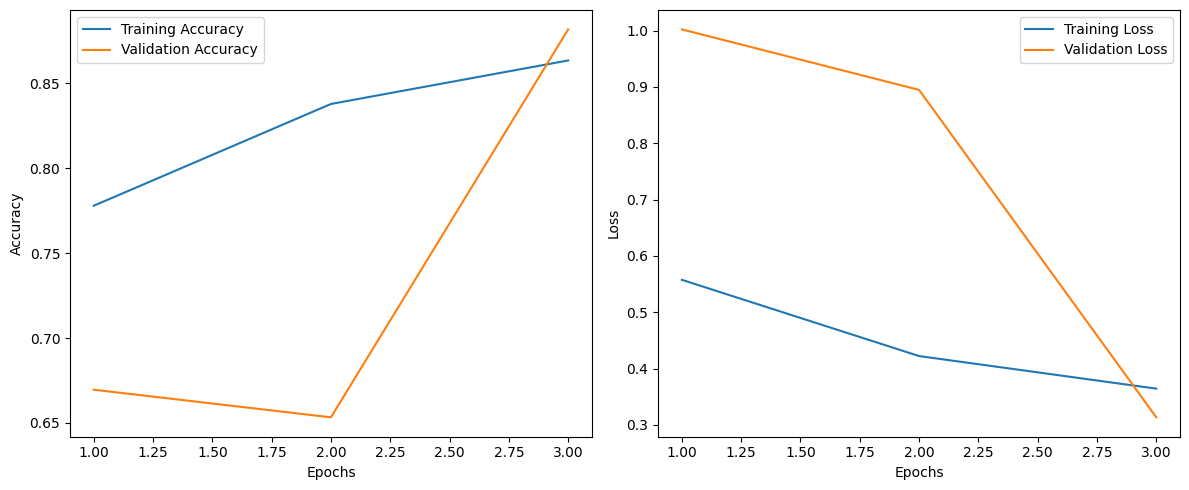

In [22]:
import matplotlib.pyplot as plt

training_acc_list = [0.7778703703703703,0.8377777777777777,0.8633796296296297]
validation_acc_list = [0.6695833333333333,0.6533333333333333,0.8816666666666667]
training_loss_list = [0.5575618950305161,0.4222550657612306,0.36440299220659117]
validation_loss_list= [1.0021165041128794,0.8947466349601746,0.31349470317363737]
# Plot training and validation accuracy over time
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1),training_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1),validation_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over time
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1),training_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1),validation_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
import h5py
hdf5_filepath = 'resnet_model.h5'

with h5py.File(hdf5_filepath, 'w') as hdf5_file:
    # Create a group to store the model parameters
    model_group = hdf5_file.create_group('resnet_model')

    # Save the model parameters to the HDF5 file
    for name, param in resnet_model_rd.state_dict().items():
        model_group.create_dataset(name, data=param.numpy())
